# Import libraries

In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import colors
import h5py
import re
from typing import Optional
import datetime as dt

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_prim_quench_ee_plateau2 import RBFPAPrimQuenchEEPlateau2
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench
from src.utils.frequency_utils import get_fft_of_DataArray
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_NMF, plot_nmf_event_composition, plot_avg_component_weight, plot_distribution_over_column, plot_component_distribution, plot_cweight_distribution_all_data
from src.visualisation.visualisation import make_gif
from src.models.nmf import NMF
from src.utils.utils import pd_dict_filt, nanargsort, merge_array
from src.utils.sort_utils import map_position_index, center_array, split_main_mirror, calc_snr, main_mirror_to_el, generate_sorted_value_dict

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')


# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier'])
len(mp3_fpa_df), len(mp3_fpa_df_unique)

(3981, 822)

In [5]:
mp3_fpa_df_unique['I_Q_kA'] = mp3_fpa_df_unique["I_Q_M"].apply(lambda x: np.round(x / 1e3)*1e3)
mp3_fpa_df_unique['dI_dt_from_data_round'] = mp3_fpa_df_unique["dI_dt_from_data"].apply(lambda x: int(np.round(x)))

mp3_fpa_df_unique['datetime'] = pd.to_datetime(mp3_fpa_df_unique['Date (FGC)'])
mp3_fpa_df_unique['year'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.year)
mp3_fpa_df_unique['month'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.month)
mp3_fpa_df_unique['day'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.day)

# Read metadata

In [6]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,age,Manufacturer,Inner cable type,Outer cable type,I_Q_SM18,Renamed short magnet ID,MTF Status,Magnet_construction_order,QPS Crate Number,Cryostat Number
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,14.0,3.0,01B,02B8,11488.0,NaN,NaN,288,0,0
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,14.0,2.0,01E,02C0,10622.0,NaN,NaN,256,0,1
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,14.0,2.0,01E,02C9,12427.0,NaN,NaN,330,1,0
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,14.0,2.0,01E,02C9,11155.0,NaN,NaN,319,2,1
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,14.0,1.0,01E,02B8,11782.0,NaN,NaN,296,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,14.0,3.0,01B,02G,12645.0,NaN,NaN,123,1,1
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,14.0,1.0,01B,02B5,12379.0,NaN,NaN,62,1,0
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,14.0,2.0,01B,02K,11757.0,NaN,NaN,61,2,1
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,14.0,3.0,01B,02G,11656.0,NaN,NaN,172,0,0


In [7]:
mp3_fpa_df_unique = mp3_fpa_df_unique.merge(rb_magnet_metadata,
                                            left_on=["Magnet"],
                                            right_on=["Magnet"],
                                            how="left", suffixes=('', '_y'))

drop_columns = mp3_fpa_df_unique.filter(regex='Unnamed').columns.to_list()
drop_columns += mp3_fpa_df_unique.filter(regex='_y').columns.to_list()
mp3_fpa_df_unique = mp3_fpa_df_unique.drop(columns=drop_columns)

# Read position map

In [8]:
pos_map_path = Path("../data/circuit_sort.csv")
df_pos_map = pd.read_csv(pos_map_path)

In [9]:
df_pos_map_subset = df_pos_map[(df_pos_map["Circuit"] == 'RB.A12') & (df_pos_map["El. Quench Position"] == 0)].reset_index(drop=True)
value_columns = df_pos_map_subset.filter(regex= ". ").columns
df_pos_map_subset[value_columns] = (df_pos_map_subset[value_columns] +1)
df_pos_map_subset.T

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
Circuit,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,...,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12
Magnet,MB.A8L2,MB.A9L2,MB.A10L2,MB.A11L2,MB.A12L2,MB.C12L2,MB.B13L2,MB.A14L2,MB.C14L2,MB.B15L2,...,MB.C15L2,MB.A15L2,MB.B14L2,MB.C13L2,MB.A13L2,MB.B12L2,MB.B11L2,MB.B10L2,MB.B9L2,MB.B8L2
El. Position,1,2,3,4,5,6,7,8,9,10,...,145,146,147,148,149,150,151,152,153,154
Phys. Position,154,152,150,148,146,144,142,140,138,136,...,135,137,139,141,143,145,147,149,151,153
Phys. Dist. to PC,1,3,5,7,9,11,13,15,17,19,...,20,18,16,14,12,10,8,6,4,2
Phys. Position ODD,154,152,150,148,146,144,142,140,138,136,...,135,137,139,141,143,145,147,149,151,153
Phys. Position EVEN,2,4,6,8,10,12,14,16,18,20,...,19,17,15,13,11,9,7,5,3,1
El. Quench Position,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Phys. Quench Position,154,154,154,154,154,154,154,154,154,154,...,154,154,154,154,154,154,154,154,154,154
Phys. Dist. to Quench,155,153,151,149,147,145,143,141,139,137,...,136,138,140,142,144,146,148,150,152,154


In [10]:
df_pos_map = df_pos_map.set_index(['Circuit', 'El. Quench Position', 'Phys. Quench Position']) # allows faster indexing

# Load Data

In [16]:
len(dataset_2EE.time)

648

In [14]:
dataset_1EE.time[-1] - dataset_1EE.time[0], dataset_2EE.time[-1] - dataset_2EE.time[0]

(<xarray.DataArray 'time' ()>
 array(0.295788), <xarray.DataArray 'time' ()>
 array(0.605616))

In [11]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
dataset_path_2EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_RBFPAPrimQuenchEEPlateau2")

dataset_creator_1EE = RBFPAPrimQuenchEEPlateau()
dataset_creator_2EE = RBFPAPrimQuenchEEPlateau2()

all_fpa_identifiers = mp3_fpa_df.fpa_identifier.unique()

dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=all_fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation'])

dataset_2EE = dataset_creator_2EE.load_dataset(fpa_identifiers=all_fpa_identifiers,
                                       dataset_path=dataset_path_2EE,
                                       drop_data_vars=['simulation'])

# interpolate time
new_time = np.linspace(dataset_1EE.time[0], dataset_1EE.time[-1], len(dataset_1EE.time)*2)
dataset_1EE["data"] = dataset_1EE.data.interp(time=new_time)

#scale time series signal
dataset_1EE["data"] = dataset_1EE.data - dataset_1EE.data.mean(dim=["el_position"], keep_attrs=True) #el_position
dataset_2EE["data"] = dataset_2EE.data - dataset_2EE.data.mean(dim=["el_position"], keep_attrs=True)

max_freq = 360
dataset_1EE_fft = get_fft_of_DataArray(data=dataset_1EE.data, cutoff_frequency=max_freq)
dataset_2EE_fft = get_fft_of_DataArray(data=dataset_2EE.data, cutoff_frequency=max_freq)

# postprocess fft data
data_1EE_ff_scaled = np.array([dataset_creator_1EE.log_scale_data(x, vmin=1e-3, vmax=10) for x in dataset_1EE_fft.data])
data_2EE_ff_scaled = np.array([dataset_creator_2EE.log_scale_data(x, vmin=1e-3, vmax=10) for x in dataset_2EE_fft.data])

data_1EE = np.nan_to_num(data_1EE_ff_scaled.reshape(-1, np.shape(data_1EE_ff_scaled)[2]))
data_2EE = np.nan_to_num(data_2EE_ff_scaled.reshape(-1, np.shape(data_2EE_ff_scaled)[2]))

TypeError: get_fft_of_DataArray() got an unexpected keyword argument 'cutoff_frequency'

## Define training data

In [ ]:
# all events with successfully loaded data
fpa_identifiers = all_fpa_identifiers[np.isin(all_fpa_identifiers, dataset_1EE.event.values)] 

# model is not trained on data before 2021 and events with fast secondary quenches
bool_R2 =  (mp3_fpa_df['timestamp_fgc'] < 1611836512820000000)
bool_fast = ((mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 < 5) & (mp3_fpa_df['Nr in Q event'].astype(str) !='1')) 
bool_test = bool_R2 | bool_fast
            
fpa_identifiers_test = fpa_identifiers[np.isin(fpa_identifiers, mp3_fpa_df[bool_test].fpa_identifier.unique())]

bool_train = ~np.isin(fpa_identifiers, fpa_identifiers_test)
fpa_identifiers_train = fpa_identifiers[bool_train]
print(len(fpa_identifiers_train), len(fpa_identifiers_test))

# add dims for indexing flattended data
bool_train_1EE = np.stack([bool_train for l in range(data_1EE_ff_scaled.shape[1])]).T.reshape(-1)
bool_train_2EE = np.stack([bool_train for l in range(data_2EE_ff_scaled.shape[1])]).T.reshape(-1)

# <h1><center><font size="30">Non-negative components - NMF</font></center></h1>

<h1><font size="8">1st Energy Extraction Plateau</font></h1>

In [21]:
data_1EE[bool_train_1EE].shape

(65450, 116)

In [22]:
hyperparameter = {
    "n_components": 5,#8
    "solver": "cd",
    "beta_loss": 'frobenius',
    "init": "nndsvd",
    "tol": 1e-5,
    "max_iter": 500,
    "l1_ratio": 0.5,
    "alpha": 0.1,
    "shuffle": "False",
    "ortho_reg": 0 
}
nmf_model = NMF(**hyperparameter)
nmf_model.fit(X=data_1EE[bool_train_1EE])
W_1EE = nmf_model.transform(X=data_1EE)
H_1EE = nmf_model.components_

plot_nmf_components(H_1EE, W_1EE, dataset_1EE_fft, vmin=1e-3, vmax=10, hyperparameters=hyperparameter)

ValueError: Array passed to NMF (input H) is full of zeros.

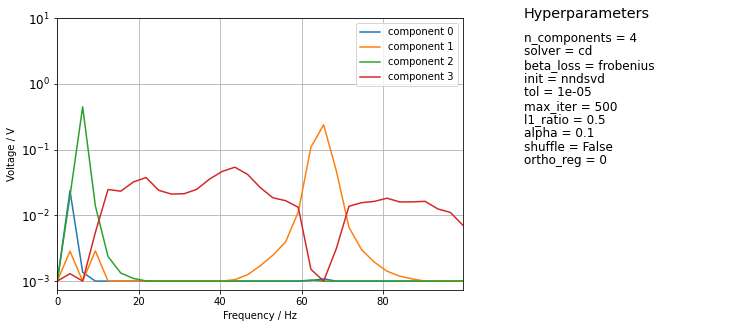

In [63]:
merge_component_index = [0,1,2,3] #[0,[3,5],7,[1,4],[2,6]] # [0,1,2,3,4]
H_1EE_merged = merge_array(H_1EE.T, merge_component_index, axis=-1, func=np.sum).T
W_1EE_merged = merge_array(W_1EE, merge_component_index, axis=-1, func=np.mean)

H_1EE_processed, component_weights_1EE = nmf_model.normalize_H(H=H_1EE_merged, W=W_1EE_merged)
plot_nmf_components(H_1EE_merged, W_1EE_merged, dataset_1EE_fft, vmin=1e-3, vmax=10, hyperparameters=hyperparameter)

# Analyze loss of NMF

In [64]:
loss = np.linalg.norm(np.nan_to_num(data_1EE_ff_scaled) - (W_1EE @ H_1EE).reshape(data_1EE_ff_scaled.shape), axis=(1,2))

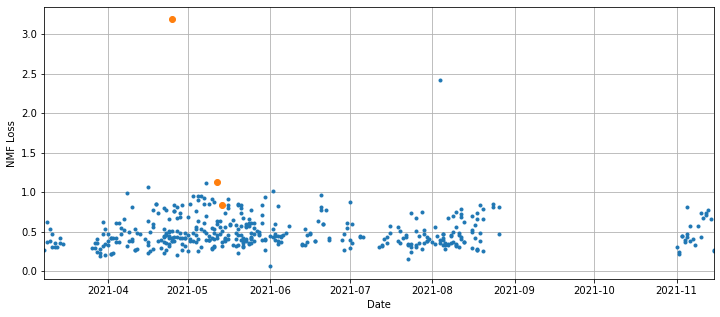

In [65]:
def sort_data_by_event_column(data, event_sort, mp3_fpa_df_subset, bool_train):
    mp3_fpa_df_sorted = mp3_fpa_df_subset.reset_index(drop=True)[bool_train].sort_values(by=event_sort)
    event_sort_index = mp3_fpa_df_sorted.index.values
    x_axis_data = mp3_fpa_df_sorted[event_sort].values
    return x_axis_data, data[event_sort_index]

mp3_fpa_df_subset = mp3_fpa_df_unique[mp3_fpa_df_unique.fpa_identifier.isin(fpa_identifiers)]

outlier_events = ["RB_RB.A78_1619330143440000000", "RB_RB.A12_1621014819920000000", "RB_RB.A45_1620797547820000000", "RB_RB.A34_1620323722320000000" ]
outlier_index = np.isin(dataset_1EE.event.values, outlier_events)

x_train, y_train = sort_data_by_event_column(loss, ['datetime'], mp3_fpa_df_subset, bool_train)
x_test, y_test = sort_data_by_event_column(loss, ['datetime'], mp3_fpa_df_subset, ~bool_train)
x_outl, y_outl = sort_data_by_event_column(loss, ['datetime'], mp3_fpa_df_subset, outlier_index)

plt.figure(figsize=(12,5))
plt.plot(x_train, y_train, ".")
plt.plot(x_outl, y_outl, "o")
#plt.plot(x_test, y_test, ".")

plt.xlim((x_train[0],x_train[-1]))
plt.ylabel("NMF Loss")
plt.xlabel("Date")
plt.grid()
plt.show()

1 RB_RB.A78_1619330143440000000
2 RB_RB.A67_1628099016180000000
3 RB_RB.A45_1620797547820000000
4 RB_RB.A12_1620503728760000000
5 RB_RB.A34_1618554915460000000
6 RB_RB.A12_1622652123200000000
7 RB_RB.A34_1617911657680000000
8 RB_RB.A56_1624200516900000000
9 RB_RB.A34_1620323722320000000
10 RB_RB.A12_1620061386640000000


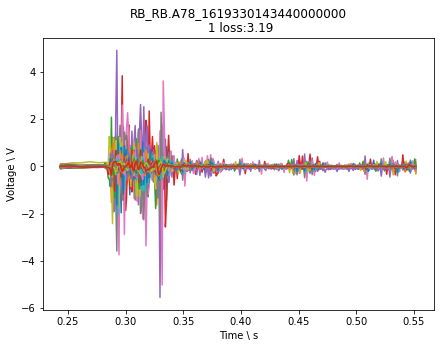

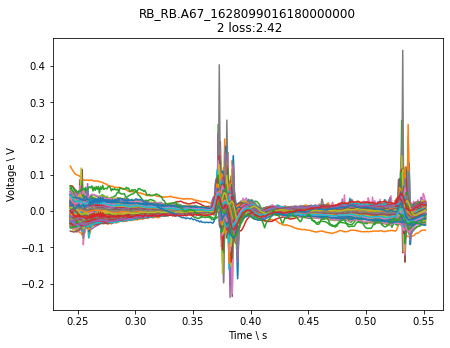

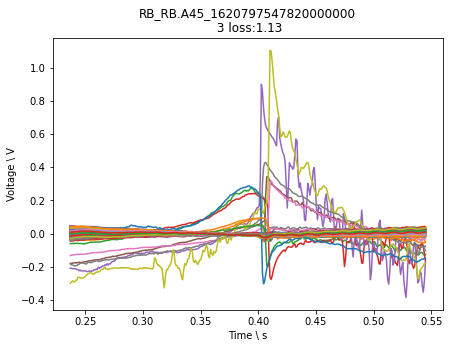

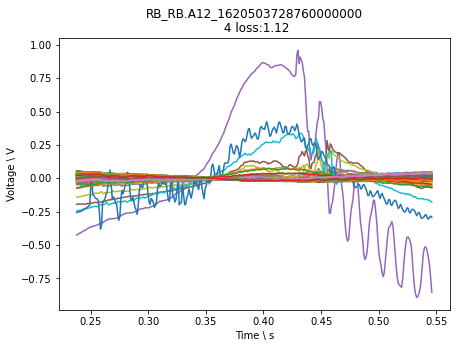

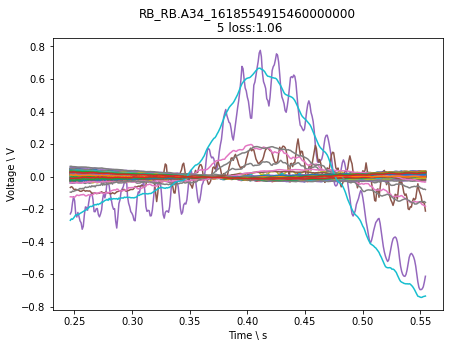

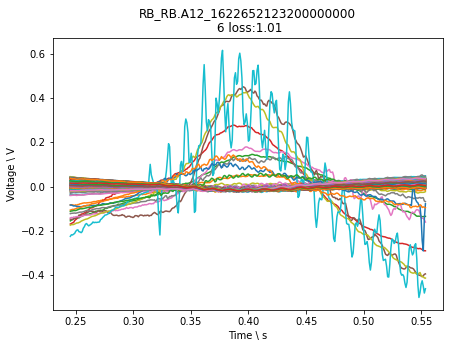

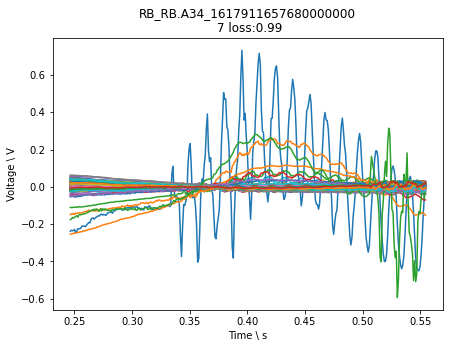

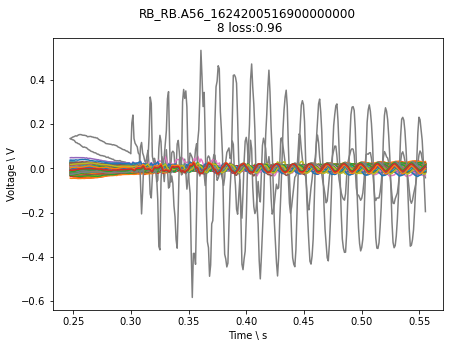

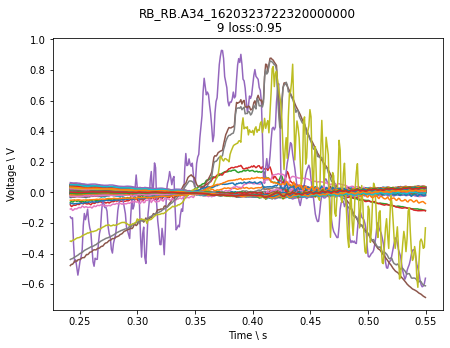

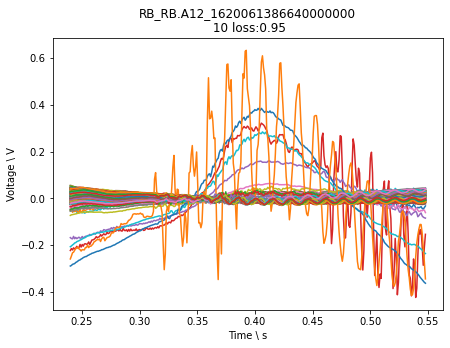

In [67]:
plot_n_events = 10

j=1
for i in np.argsort(loss[bool_train])[::-1][:plot_n_events]: #
    event_idex = np.arange(len(loss))[bool_train][i]
    plt.figure(figsize=(7,5))
    plt.plot(dataset_1EE[{'event': event_idex}].time, dataset_1EE[{'event': event_idex}].data.T)
    fpa_i = dataset_1EE[{'event': event_idex}].event.values
    #plt.title(f"{fpa_i}\n {mp3_fpa_df_unique[mp3_fpa_df_unique.fpa_identifier == fpa_i]['datetime'].dt.strftime('%Y-%m-%d').values[0]}")
    plt.title(f"{dataset_1EE[{'event': event_idex}].event.values}\n {j} loss:{loss[bool_train][i]:.2f}")
    print(f"{j} {dataset_1EE[{'event': event_idex}].event.values}")
    plt.ylabel("Voltage \ V")
    plt.xlabel("Time \ s")
    j+=1

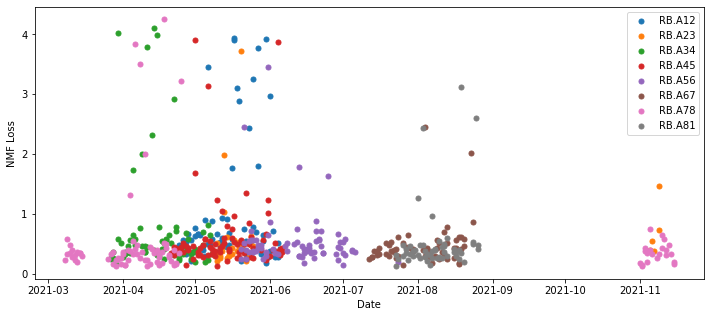

In [61]:
fpa_precursor = "RB_RB.A78_1616962174400000000"

plt.figure(figsize=(12,5))
for i, circuit in enumerate(rb_magnet_metadata.Circuit.unique()):
    index = ((mp3_fpa_df_subset.year == 2021) & (mp3_fpa_df_subset.Circuit == circuit)).values
    x_train, y_train = sort_data_by_event_column(loss, ['datetime'], mp3_fpa_df_subset, index)
    plt.plot(x_train, y_train, ".", label=circuit, ms=10)
    
plt.ylabel("NMF Loss")
plt.xlabel("Date")
plt.legend()
plt.show()

## Check components

In [68]:
use_fpa_identifier = False
if use_fpa_identifier:
    # provide fpa_identifier
    fpa_identifier = "RB_RB.A67_1629264982960000000" ##"RB_RB.A81_1627051635280000000" #"RB_RB.A78_1618898296760000000",
    event_idex = np.argmax(fpa_identifiers == fpa_identifier)
else: 
    # provide event_index 
    event_idex = 2 #30
    dataset_fft_cut = dataset_1EE_fft.loc[{'event': fpa_identifiers}]
    fpa_identifier =  dataset_fft_cut[{'event': event_idex}].event.values

date = mp3_fpa_df[mp3_fpa_df.fpa_identifier == fpa_identifier]['Timestamp_PIC'].values[0]
event_idex, fpa_identifier, date

(2, array('RB_RB.A12_1544119359400000000', dtype='<U29'), nan)

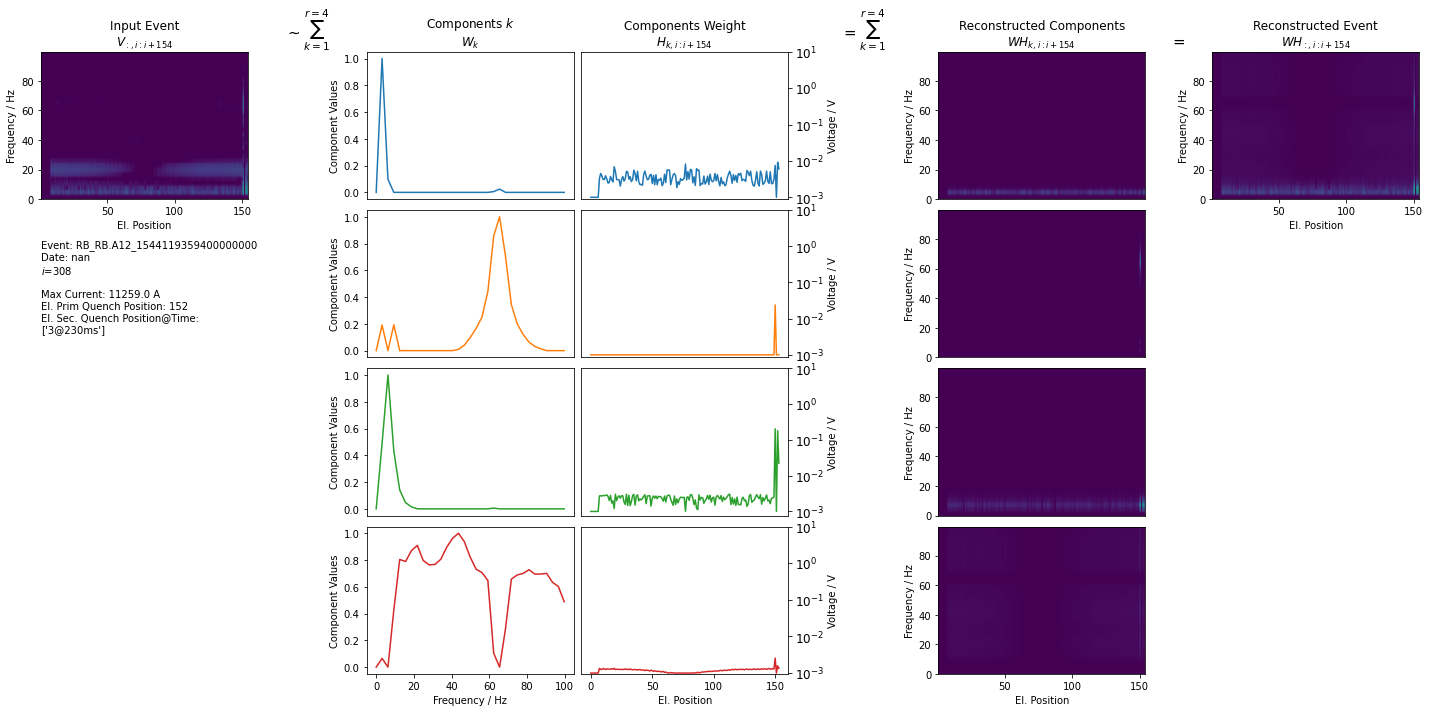

In [69]:
component_indexes_1EE = [0, 1, 2, 3] 
plot_nmf_event_composition(data_1EE, component_weights_1EE, H_1EE_processed, component_indexes_1EE, dataset_1EE_fft, fpa_identifier, mp3_fpa_df, vmin=1e-3, vmax=10)

# Understand components

In [75]:
n_magnets = 154
component_weights_1EE_reshaped = W_1EE.copy().reshape(-1, 154, len(W_1EE[0]))
component_weight_event = component_weights_1EE_reshaped[fpa_identifiers ==fpa_identifier][0]
c_events = np.argmax(component_weight_event, axis=0)
c_frequencies = dataset_1EE_fft.frequency[H_1EE.argmax(axis=1)] #maximal frequency of each component

reconstructed_fpm = component_weight_event @ H_1EE

In [71]:
c_frequencies

<xarray.DataArray 'frequency' (frequency: 4)>
array([ 3.114799, 65.41078 ,  6.229598, 43.607186])
Coordinates:
  * frequency  (frequency) float64 3.115 65.41 6.23 43.61

Text(0.5, 1.0, 'reconstruction')

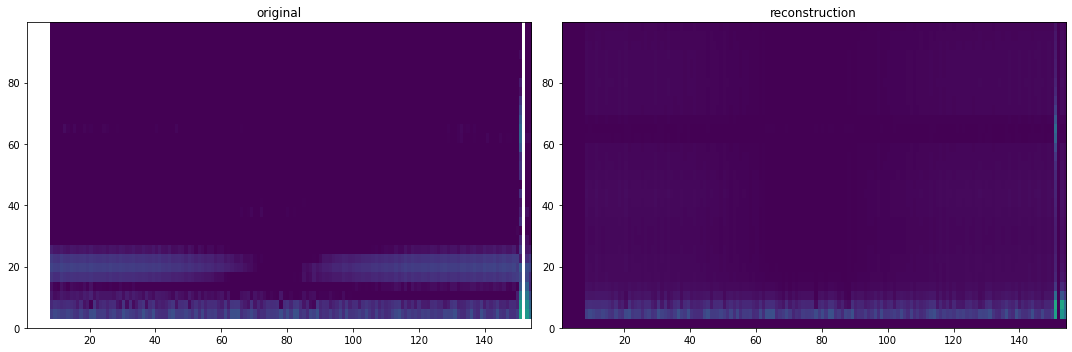

In [76]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plot_position_frequency_map(ax[0], dataset_1EE_fft.loc[{'event': fpa_identifier}].data, dataset_1EE_fft.frequency, vmin=1e-3 ,vmax=10)
ax[0].set_title("original")
plot_position_frequency_map(ax[1], component_weight_event @ H_1EE, dataset_1EE_fft.frequency, norm=None, vmin=0 ,vmax=1)
ax[1].set_title("reconstruction")

In [77]:
def unscale_log_min_max(x, vmin= 1e-3, vmax= 10):
    vdiff = np.log10(vmax) - np.log10(vmin)
    x_log = np.log10(vmin) +  vdiff * x
    return 10**x_log

In [1]:
fig, ax = plt.subplots(1,2, figsize =(25,10))
cmap = mpl.cm.jet #mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors_2 + colors_1)
norm = mpl.colors.Normalize(vmin=1, vmax=154)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[1], fraction=0.1, orientation = 'vertical')
cbar.set_label('El. Position')

for i, signal in enumerate(dataset_1EE.loc[{"event":fpa_identifier}].data):
    if i in c_events:
        stronges_components = np.arange(len(c_events))[c_events==i]
        ax[0].plot(dataset_1EE.time, signal.T, c=cmap(i/n_magnets), lw =2, label=f"components {stronges_components}")
    else:
        ax[0].plot(dataset_1EE.time, signal.T, c=cmap(i/n_magnets), alpha=0.1)

for j, events in enumerate(c_events):
    log_amplitude = np.max(component_weight_event, axis=0)[j] * H_1EE.max(axis=1)[j] # H_1EE_merged, W_1EE_merged
    
    signal = np.sin(2*np.pi*(c_frequencies[j]+0.001) * dataset_1EE.time) * unscale_log_min_max(log_amplitude) 
    ax[1].plot(dataset_1EE.time, signal, c=cmap(events/n_magnets), label=f"{c_frequencies[j].values:.1f} Hz" )
    
    ax[1].set_ylim(ax[0].get_ylim())
    
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## Distribution of Component weights

In [ ]:
component_weights_1EE_reshaped = component_weights_1EE.copy().reshape(-1, 154, len(merge_component_index))

mp3_fpa_df_subset = mp3_fpa_df_unique[mp3_fpa_df_unique.fpa_identifier.isin(fpa_identifiers)]
mp3_fpa_df_pos_subset = mp3_fpa_df_subset.rename(columns={'#Electric_circuit':"El. Quench Position", 'phys_position': "Phys. Quench Position"})
mp3_fpa_df_pos_subset[["El. Quench Position",  "Phys. Quench Position"]] = mp3_fpa_df_pos_subset[["El. Quench Position",  "Phys. Quench Position"]] - 1

In [ ]:
c_weights_dict = generate_sorted_value_dict(values=component_weights_1EE_reshaped, df_pos_map=df_pos_map, df_event_context=mp3_fpa_df_pos_subset)

# Distribution over Sector and Time

In [ ]:
plot_component_distribution(c_weights_dict, mp3_fpa_df_subset, event_sort=["Circuit","datetime"], event_sort_ticks="Circuit", is_date=False)

In [ ]:
plot_component_distribution(c_weights_dict, mp3_fpa_df_subset, event_sort=["Manufacturer","datetime"], event_sort_ticks="Manufacturer", is_date=False)

In [ ]:
plot_component_distribution(c_weights_dict, mp3_fpa_df_subset, event_sort=["Circuit","datetime"], event_sort_ticks="Circuit", is_date=False, event_index=~bool_train)

In [ ]:
#plot_distribution_over_column(c_weights_dict, mp3_fpa_df_unique, fpa_identifiers, column="Circuit", columns_values=rb_magnet_metadata.Circuit.unique())

In [ ]:
#plot_distribution_over_column(c_weights_dict, mp3_fpa_df_unique, fpa_identifiers, column="month", columns_values=mp3_fpa_df_unique[mp3_fpa_df_unique.year ==2021].month.unique())

In [ ]:
#plot_distribution_over_column(c_weights_dict, mp3_fpa_df_unique, fpa_identifiers, column="I_Q_kA", columns_values=mp3_fpa_df_unique[mp3_fpa_df_unique.fpa_identifier.isin(fpa_identifiers)]["I_Q_kA"].sort_values().unique())

# Plot frequency as a function of context variables

In [ ]:
def plot_feature_correlation(mp3_fpa_df_subset, column, f=np.mean):
    
    df = pd.DataFrame(np.zeros((len(mp3_fpa_df_subset[column].unique()), len(dataset_1EE_fft.frequency.values))).T ,columns=[f"{column} {i}" for i in mp3_fpa_df_subset.sort_values(by=column)[column].unique()], index=dataset_1EE_fft.frequency.values )
    
    fig, ax = plt.subplots(1,1, figsize=(12,7))
    for i, m in enumerate(mp3_fpa_df_subset.sort_values(by=column)[column].unique()):
        index = ((mp3_fpa_df_subset.year == 2021) & (mp3_fpa_df_subset[column] == m)).values
        #df[f"{column} {m}"]
        data = f(dataset_1EE_fft[index], axis=1).mean(axis=0) # max over all magnets, mean over all events
        ax.plot(dataset_1EE_fft.frequency, data, label=f"magnet {column} {m} ({sum(index)})")
        #ax.plot(data, '.')
    
    #df.plot(marker=".", figsize=(12,7), markersize=5)
    plt.legend()
    plt.yscale("log")
    plt.ylabel("Voltage / V")
    plt.xlabel("Frequency / Hz")
    plt.title(f"{f.__name__} Voltage in Circuit, Average over all events")
    plt.grid()

In [ ]:
column = "age"
plot_feature_correlation(mp3_fpa_df_subset, column)

In [ ]:
column = "Manufacturer"
plot_feature_correlation(mp3_fpa_df_subset, column)
plt.figure()
for m in mp3_fpa_df_unique["Manufacturer"].unique():
    mp3_fpa_df_unique[mp3_fpa_df_unique["Manufacturer"]==m]["Circuit"].hist(bins=8, alpha=0.5, label=f"Manufacturer {m}")
plt.legend()
plt.tight_layout()

In [ ]:
column = "Circuit"
plot_feature_correlation(mp3_fpa_df_subset, column)

## Analyze Compent 3

In [ ]:
component = 3
circuits = rb_magnet_metadata.Circuit.unique() 
    
for circuit in circuits:
    fig, ax = plt.subplots(figsize=(12,5))

    
    circuit_fpa_identifiers = mp3_fpa_df_unique[mp3_fpa_df_unique["Circuit"] == circuit].fpa_identifier
    circuit_bool = np.isin(fpa_identifiers, circuit_fpa_identifiers)

    rb_magnet_metadata_subset = rb_magnet_metadata[rb_magnet_metadata.Circuit == circuit]
    last_mag_in_crate = rb_magnet_metadata_subset.groupby("QPS Crate").max().sort_values(by='#Electric_circuit')["#Electric_circuit"].values

    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ax.plot(np.arange(1,155), np.mean(c_weights_dict["El. Position"]["values"][circuit_bool,:, component], axis=0), c=default_colors[component])

    ax.set_xticks(last_mag_in_crate)
    tick_labels = [str(l) if i % 3 == 0 else '' for i, l in enumerate(last_mag_in_crate)]
    ax.set_xticklabels(tick_labels)

    ax.set_title(f"{circuit} Component {component}")
    ax.set_xlabel(f"El. Position (Grid: QPS Crates)")
    ax.set_xlim((1,154))
    
    yticks = ax.get_yticks().tolist()
    ax.set_yticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in yticks], fontsize="large")
    ax.set_ylabel("Voltage / V")

    plt.grid()
    plt.show()

In [ ]:
import seaborn as sns
from scipy.signal import find_peaks

component = 3
peaks = find_peaks(H_1EE_processed[component], height=0.2)

mp3_fpa_df_subset["Hz143_oscillation"] = dataset_1EE_fft.mean(axis=1)[:, peaks[0][0]]


#mp3_fpa_df_subset.plot.scatter(x="I_Earth_max", y="Hz143_oscillation",  ylim=(0,0.002), xlim=(52,65))
sns.jointplot(data=mp3_fpa_df_subset.sort_values(by="Circuit"), x="I_Earth_max", y="Hz143_oscillation", hue="Circuit",ratio=3, height=8, ylim=(-0.0001,0.001), xlim=(52,68), space=0) 
sns.jointplot(data=mp3_fpa_df_subset.sort_values(by="Circuit"), x="I_end_2_from_data", y="Hz143_oscillation", kind="reg",ratio=3, height=8, ylim=(0,0.001), xlim=(0.9e4,1.2e4), space=0) 
sns.jointplot(data=mp3_fpa_df_subset.sort_values(by="Circuit"), x="R_EE_odd", y="Hz143_oscillation", hue="Circuit",ratio=3, height=8, ylim=(0,0.001), xlim=(0.068,0.073), space=0) 

## Analyze Compent 4

In [ ]:
from scipy.signal import find_peaks

component = 4
circuit = 'RB.A78' #rb_magnet_metadata.Circuit.unique() 
    
peaks = find_peaks(H_1EE_processed[4], height=0.2)
frequency = dataset_1EE_fft.frequency.values

fig, ax = plt.subplots(figsize=(12,7))

circuit_fpa_identifiers = mp3_fpa_df_unique[mp3_fpa_df_unique["Circuit"] == circuit].fpa_identifier
circuit_bool = np.isin(fpa_identifiers, circuit_fpa_identifiers)

rb_magnet_metadata_subset = rb_magnet_metadata[rb_magnet_metadata.Circuit == circuit]
last_mag_in_crate = rb_magnet_metadata_subset.groupby("QPS Crate").max().sort_values(by='#Electric_circuit')["#Electric_circuit"].values

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, p in enumerate(peaks[0]):
    plot_values = np.mean(c_weights_dict["El. Position"]["values"][circuit_bool,:, component], axis=0) * H_1EE_processed[4,p]

    #ax.plot(np.arange(1,155), plot_values,"x") # c=default_colors[component]
    ax.plot(np.arange(1,155), plot_values, lw=1.5, label=f"{frequency[p]:.1f} Hz")

plt.legend()
    
ax.set_title(f"{circuit} Average Amplitude of 105 Hz, 210 Hz, 250 Hz, 315 Hz and 350 Hz Oscillations")
ax.set_xlabel(f"El. Position")
ax.set_xlim((1,154))

yticks = ax.get_yticks().tolist()
ax.set_yticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in yticks], fontsize="large")
ax.set_ylabel("Voltage / V")

plt.grid()
plt.show()

In [ ]:
from scipy.signal import find_peaks

peaks = find_peaks(H_1EE_processed[4], height=0.2)
frequency = dataset_1EE_fft.frequency.values

plt.plot(frequency, H_1EE_processed[4])
plt.plot(frequency[peaks[0]], H_1EE_processed[4,peaks[0]],"x")
print(frequency[peaks[0]])

fig, ax = plt.subplots(figsize=(12,7))
for i, p in enumerate(peaks[0]):
    plt.plot(np.arange(1,155),dataset_1EE_fft[circuit_bool].median(axis=0)[:, p], label=f"{frequency[p]:.1f} Hz")
 
    
plt.grid()
plt.yscale('log')
plt.ylim((1e-5, 1e-3))
plt.xlim((1, 154))
plt.legend()

ax.set_xlabel(f"El. Position")
ax.set_ylabel("Voltage / V")
ax.set_title(f"{circuit} U diode frequency amplitude (median over {sum(circuit_bool)} FPA events)")
plt.show()

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(20,20))

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, circuit in enumerate(rb_magnet_metadata.Circuit.unique()):
    
    index = ((mp3_fpa_df_subset.year == 2021) & (mp3_fpa_df_subset.month <11) & (mp3_fpa_df_subset.Circuit == circuit)).values
    
    data = np.nanmedian(c_weights_dict['El. Dist. to Quench Main']["values"][..., 2], axis=1) 
    data_mirror = np.nanmedian(c_weights_dict['El. Dist. to Quench Mirror']["values"][..., 2], axis=1) 
    
    x_train, y_train = sort_data_by_event_column(data, ['datetime'], mp3_fpa_df_subset, index)
    x_train_mirror, y_train_mirror = sort_data_by_event_column(data_mirror, ['datetime'], mp3_fpa_df_subset, index)

    ax[0].plot(x_train, y_train, ".", label=circuit, ms=5, c =default_colors[i])
    ax[1].plot(x_train_mirror, y_train_mirror, ".", label=circuit, ms=5, c =default_colors[i])
    ax[2].plot(x_train, mp3_fpa_df_subset[index].I_Q_M.values, "." , label=circuit, ms=8, c =default_colors[i])
    
    x_sec = [(x[0] - x_train[0][0]).item() / 1e9  for x in x_train]
    z = np.polyfit(x_sec, y_train, 1)
    p = np.poly1d(z)
    ax[0].plot(x_train, p(x_sec),"--", c =default_colors[i], lw=3)
    
    x_sec = [(x[0] - x_train[0][0]).item() / 1e9  for x in x_train_mirror]
    z = np.polyfit(x_sec, y_train_mirror, 1)
    p = np.poly1d(z)
    ax[1].plot(x_train, p(x_sec),"--", c =default_colors[i], lw=3)
    

plt.ylabel("Energy Component 2")
plt.xlabel("Date")

ax[0].set_ylim((0,0.5))
ax[1].set_ylim((0,0.5))

yticks = ax[0].get_yticks().tolist()
ax[0].set_yticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in yticks], fontsize="large")
ax[0].set_ylabel("Voltage / V")

yticks = ax[1].get_yticks().tolist()
ax[1].set_yticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in yticks], fontsize="large")
ax[1].set_ylabel("Voltage / V")


plt.ylim((10000,12000))
plt.ylabel("I_Q_M / A")
plt.xlabel("Date")

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_title("Mean H value El. Position Main")
ax[1].set_title("Mean H value El. Position Mirror")
ax[2].set_title("I_Q_M")
plt.show()

In [ ]:
event_sort_ticks = "Circuit"
event_index = bool_train
event_sort=["Circuit","datetime"]
mp3_fpa_df_sorted = mp3_fpa_df_subset.reset_index(drop=True)[event_index].sort_values(by=event_sort)
event_sort_index = mp3_fpa_df_sorted.index.values
mp3_fpa_df_sorted = mp3_fpa_df_sorted.reset_index()

first_entry_df = mp3_fpa_df_sorted[event_sort_ticks].drop_duplicates()
y_tick_index = first_entry_df.index.values
yticklabels = mp3_fpa_df_sorted.iloc[y_tick_index][event_sort[0]]

extent = [1, 154, len(mp3_fpa_df_sorted), 0]

n_features = len(dataset_1EE["el_position_feature_name"].values)
fig, ax = plt.subplots(1, n_features, figsize=(4 * (n_features), 10))

for n, feature in enumerate(dataset_1EE["el_position_feature_name"].values):
    el_position_features = dataset_1EE.loc[{"el_position_feature_name": feature}]["el_position_feature"].values
    
    im = ax[n].imshow(el_position_features[event_sort_index], extent=extent, cmap="magma", origin="upper", aspect="auto")

    ax[n].set_xlabel(f"El. Position")
    ax[n].set_ylabel(f"{event_sort_ticks}")
    ax[n].set_title(feature)

    ax[n].set_yticks(y_tick_index[::-1])
    ax[n].set_yticklabels(yticklabels[::-1])

plt.tight_layout()
plt.show()

## All data distribution

In [ ]:
best_sort_index = plot_cweight_distribution_all_data(H_1EE_processed, c_weights_dict, dataset_1EE_fft.frequency)

<h1><font size="8">2nd Energy Extraction Plateau</font></h1>

In [ ]:
hyperparameter = {
    "n_components": 12,
    "solver": "cd",
    "beta_loss": 'frobenius',
    "init": "nndsvd",
    "tol": 1e-3,
    "max_iter": 200,
    "l1_ratio": 0.5,
    "alpha": 1,
    "shuffle": "False",
    "ortho_reg": 0 
}
nmf_model = NMF(**hyperparameter)
nmf_model.fit(X=data_2EE[bool_train_2EE])
W_2EE = nmf_model.transform(X=data_2EE)
H_2EE = nmf_model.components_

plot_nmf_components(H_2EE, dataset_2EE_fft)

In [ ]:
merge_component_index = [0, [1,6], [2, 4, 5, 7, 8, 9, 11], 3, 10] # [0, [1,3], [2,4,8], [9, 7,10,6], 5, 11]
H_2EE_merged = merge_array(H_2EE.T, merge_component_index, axis=-1, func=np.sum).T
W_2EE_merged = merge_array(W_2EE, merge_component_index, axis=-1, func=np.mean)

H_2EE_processed, component_weights_2EE = nmf_model.normalize_H(H=H_2EE_merged, W=W_2EE_merged)

plot_nmf_components(H_2EE_merged, dataset_2EE_fft)

## Distribution over Sector and Time

In [ ]:
component_weights_2EE_reshaped = component_weights_2EE.copy().reshape(-1, 154, len(merge_component_index))
c_weights_dict_2EE = generate_sorted_value_dict(values=component_weights_2EE_reshaped, df_pos_map=df_pos_map, df_event_context=mp3_fpa_df_pos_subset)

In [ ]:
plot_component_distribution(c_weights_dict_2EE, mp3_fpa_df_subset, event_sort=["Circuit","datetime"], event_sort_ticks="Circuit", is_date=False, event_index=bool_train)

In [ ]:
plot_component_distribution(c_weights_dict_2EE, mp3_fpa_df_subset, event_sort=["Circuit","datetime"], event_sort_ticks="Circuit", is_date=False, event_index=~bool_train)

## All data distribution

In [ ]:
best_sort_index_2EE = plot_cweight_distribution_all_data(H_2EE_processed, c_weights_dict_2EE, dataset_2EE_fft.frequency)

# Simulate FP-map given components for both EE

In [ ]:
n_quench_pos = 154
V_mean_1EE = np.zeros((n_quench_pos,) + dataset_1EE_fft.shape[1:])
for quench_pos in range(n_quench_pos):

    for i_component, i_best_sort in enumerate(best_sort_index):
        best_sort = list(c_weights_dict)[i_best_sort]
        V_mean = np.nanmean(c_weights_dict[best_sort]["values"], axis=0)[:, i_component:i_component+1] @  H_1EE_processed[i_component:i_component+1]

        if "Main" in list(c_weights_dict)[i_best_sort]:
            V_mirror = np.nanmean(c_weights_dict['El. Dist. to Quench Mirror']["values"], axis=0)[:, i_component:i_component+1] @  H_1EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_mean, V_mirror, quench_pos)
        elif "Mirror" in list(c_weights_dict)[i_best_sort]:
            V_main = np.nanmean(c_weights_dict['El. Dist. to Quench Main']["values"], axis=0)[:, i_component:i_component+1] @  H_1EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_main, V_mean, quench_pos)

        elif "Quench" in list(c_weights_dict)[i_best_sort]:
            center = int(len(V_mean) /2)
            V_mean = np.roll(V_mean, -center +quench_pos, axis=0)[center-quench_pos:len(V_mean)-quench_pos] 
        V_mean_1EE[quench_pos] += V_mean

In [ ]:
n_quench_pos = 154
V_mean_2EE = np.zeros((n_quench_pos,) + dataset_2EE_fft.shape[1:])
for quench_pos in range(n_quench_pos):

    for i_component, i_best_sort in enumerate(best_sort_index_2EE):
        best_sort = list(c_weights_dict_2EE)[i_best_sort]
        V_mean = np.nanmean(c_weights_dict_2EE[best_sort]["values"], axis=0)[:, i_component:i_component+1] @  H_2EE_processed[i_component:i_component+1]

        if "Main" in list(c_weights_dict_2EE)[i_best_sort]:
            V_mirror = np.nanmean(c_weights_dict_2EE['El. Dist. to Quench Mirror']["values"], axis=0)[:, i_component:i_component+1] @  H_2EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_mean, V_mirror, quench_pos)
        elif "Mirror" in list(c_weights_dict_2EE)[i_best_sort]:
            V_main = np.nanmean(c_weights_dict_2EE['El. Dist. to Quench Main']["values"], axis=0)[:, i_component:i_component+1] @  H_2EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_main, V_mean, quench_pos)

        elif "Quench" in list(c_weights_dict_2EE)[i_best_sort]:
            center = int(len(V_mean) /2)
            V_mean = np.roll(V_mean, -center +quench_pos, axis=0)[center-quench_pos:len(V_mean)-quench_pos] #is this right?
        V_mean_2EE[quench_pos] += V_mean

In [ ]:
output_path = Path(f"../output/nmf_decomposition.py/simulation_all")
output_path.mkdir(parents=True, exist_ok=True)

im_paths = []   
circuit = 'RB.A12'
for quench_pos in range(n_quench_pos):
    phys_pos_index = map_position_index(df_pos_map, origin="El. Position", to='Phys. Position', filt={'Circuit': circuit, 'El. Quench Position': quench_pos})
    phys_quench_pos = map_position_index(df_pos_map, old_index=[quench_pos], origin="Phys. Position", to='El. Position', filt={'Circuit': 'RB.A12', 'El. Quench Position': quench_pos})[0]
    
    fig, ax = plt.subplots(2,3, figsize = (15,10), gridspec_kw={ 'width_ratios': [4, 4, 1]})
    
    plot_position_frequency_map(ax[0, 0], V_mean_1EE[quench_pos], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[0, 0].set_title(f"U_Diode @ 1st EE, El. Quench Position: {quench_pos+1}")
    ax[0, 0].set_ylabel("Frequency / Hz")
    ax[0, 0].set_xlabel("El. Position")
    
    im = plot_position_frequency_map(ax[0, 1], V_mean_1EE[quench_pos][phys_pos_index], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[0, 1].set_title(f"{circuit}, Phys. Quench Position: {phys_quench_pos+1}")
    ax[0, 1].set_ylabel("Frequency / Hz")
    ax[0, 1].set_xlabel("Phys. Position")
    
    plot_position_frequency_map(ax[1, 0], V_mean_2EE[quench_pos], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[1, 0].set_title(f"U_Diode @ 2nd EE, El. Quench Position: {quench_pos}")
    ax[1, 0].set_ylabel("Frequency / Hz")
    ax[1, 0].set_xlabel("El. Position")
    
    plot_position_frequency_map(ax[1, 1], V_mean_2EE[quench_pos][phys_pos_index], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[1, 1].set_title(f"{circuit}, Phys. Quench Position: {phys_quench_pos+1}")
    ax[1, 1].set_ylabel("Frequency / Hz")
    ax[1, 1].set_xlabel("Phys. Position")
    
    cbar = fig.colorbar(im, ax=ax[0, 2], fraction=1)
    ax[0, 2].set_axis_off()
    cticks = cbar.get_ticks().tolist()
    cbar.set_ticks(cticks)
    cbar.set_ticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in cticks])
    cbar.set_label("Voltage / V")
    cbar.ax.tick_params(labelsize=12)
    
    cbar = fig.colorbar(im, ax=ax[1, 2], fraction=1)
    ax[1, 2].set_axis_off()
    cticks = cbar.get_ticks().tolist()
    cbar.set_ticks(cticks)
    cbar.set_ticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in cticks])
    cbar.set_label("Voltage / V")
    cbar.ax.tick_params(labelsize=12)

    im_path = output_path / f"{quench_pos+1}.png"
    im_paths.append(im_path)
    plt.tight_layout()
    #plt.savefig(im_path)
    #plt.close(fig)
    break
#make_gif(im_paths=im_paths, output_path=plot_path)